# Исследование тарифов 

Заказчик — федеральный оператор сотовой связи «Мегалайн».  
Предмет исследования два тарифных плана: «Смарт» и «Ультра».  
Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов.  
Проанализируем поведение клиентов и сделаем вывод — какой тариф лучше.  

Описание тарифов:  
* **Тариф «Смарт»**  
   Ежемесячная плата: 550 рублей  
   Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  
   Стоимость услуг сверх тарифного пакета:  
   - минута разговора: 3 рубля  
   - сообщение: 3 рубля  
   - 1 Гб интернет-трафика: 200 рублей  

* **Тариф «Ультра»**  
   Ежемесячная плата: 1950 рублей  
   Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  
   Стоимость услуг сверх тарифного пакета:  
   - минута разговора: 1 рубль  
   - сообщение: 1 рубль  
   - 1 Гб интернет-трафика: 150 рублей  

Справочно: «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт.

## Общая информация

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

In [2]:
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv', index_col=0)
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

In [3]:
name_dict = {
    'calls': {
        'id': 'уникальный номер звонка',
        'call_date': 'дата звонка',
        'duration': 'длительность звонка в минутах',
        'user_id': 'идентификатор пользователя, сделавшего звонок',
    },
    'internet': {
        'id': 'уникальный номер сессии',
        'mb_used': 'объём потраченного за сессию интернет-трафика (в мегабайтах)',
        'session_date': 'дата интернет-сессии',
        'user_id': 'идентификатор пользователя',
    },
    'messages': {
        'id': 'уникальный номер сообщения',
        'message_date': 'дата сообщения',
        'user_id': 'идентификатор пользователя, отправившего сообщение',
    },
    'tariffs': {
        'tariff_name': 'название тарифа',
        'rub_monthly_fee': 'ежемесячная абонентская плата в рублях',
        'minutes_included': 'количество минут разговора в месяц, включённых в абонентскую плату',
        'messages_included': 'количество сообщений в месяц, включённых в абонентскую плату',
        'mb_per_month_included': 'объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)',
        'rub_per_minute': 'стоимость минуты разговора сверх тарифного пакета',
        'rub_per_message': 'стоимость отправки сообщения сверх тарифного пакета',
        'rub_per_gb': 'стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета',
    },
    'users': {
        'user_id': 'уникальный идентификатор пользователя',
        'first_name': 'имя пользователя',
        'last_name': 'фамилия пользователя',
        'age': 'возраст пользователя (годы)',
        'reg_date': 'дата подключения тарифа (день, месяц, год)',
        'churn_date': 'дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)',
        'city': 'город проживания пользователя',
        'tariff': 'название тарифного плана',
    },
}

In [4]:
def df_info(df):
    name =[x for x in globals() if globals()[x] is df][0]
    display(f">>> {name} <<<")
    description = name_dict.get(name, {})
    if description:
        print('Описание столбцов:')
    for k, v in description.items():
        print(f"• {k}: {v}")
    display(df.head())
    df.info()
    print('\n——————————————————————————————————————————————————————————————————')

In [5]:
print('——————————————————————————————————————————————————————————————————')
df_info(users)
df_info(calls)
df_info(internet)
df_info(messages)
df_info(tariffs)

——————————————————————————————————————————————————————————————————


'>>> users <<<'

Описание столбцов:
• user_id: уникальный идентификатор пользователя
• first_name: имя пользователя
• last_name: фамилия пользователя
• age: возраст пользователя (годы)
• reg_date: дата подключения тарифа (день, месяц, год)
• churn_date: дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
• city: город проживания пользователя
• tariff: название тарифного плана


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

——————————————————————————————————————————————————————————————————


'>>> calls <<<'

Описание столбцов:
• id: уникальный номер звонка
• call_date: дата звонка
• duration: длительность звонка в минутах
• user_id: идентификатор пользователя, сделавшего звонок


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

——————————————————————————————————————————————————————————————————


'>>> internet <<<'

Описание столбцов:
• id: уникальный номер сессии
• mb_used: объём потраченного за сессию интернет-трафика (в мегабайтах)
• session_date: дата интернет-сессии
• user_id: идентификатор пользователя


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB

——————————————————————————————————————————————————————————————————


'>>> messages <<<'

Описание столбцов:
• id: уникальный номер сообщения
• message_date: дата сообщения
• user_id: идентификатор пользователя, отправившего сообщение


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

——————————————————————————————————————————————————————————————————


'>>> tariffs <<<'

Описание столбцов:
• tariff_name: название тарифа
• rub_monthly_fee: ежемесячная абонентская плата в рублях
• minutes_included: количество минут разговора в месяц, включённых в абонентскую плату
• messages_included: количество сообщений в месяц, включённых в абонентскую плату
• mb_per_month_included: объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
• rub_per_minute: стоимость минуты разговора сверх тарифного пакета
• rub_per_message: стоимость отправки сообщения сверх тарифного пакета
• rub_per_gb: стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes

——————————————————————————————————————————————————————————————————


Количество клиентов каждого тарифа:

In [6]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

***
### Вывод

* Таблица `users`.
   - Стоит переименовать столбцы: `reg_date` в `start_date`, `churn_date` в `end_date`.
   - Даты `reg_date` и `churn_date` необходимо привести к соответствующему формату.

* Таблица `calls`.
   - Таблица содержит список звонков, которые можно соотнести с пользователем по `user_id`.
   - Из-за логики работы тарифов стоит округлить длительность звонков `duration` до минут в б́ольшую сторону.
   - Дату `call_date` необходимо привести к соответствующему формату.
   - Стоит добавить столбец названия месяца `month` для  будущего анализа. 
   - Предварительно необходимо проверить, что данные взяты в рамках одного календарного года.

* Таблица `internet`.
   - Необходимо удалить задвоенный столбец индексов `Unnamed`.
   - Таблица содержит список интернет-сессий, которые можно соотнести с пользователем по `user_id`.
   - Аналогично таблице `calls` необходимо `session_date` необходимо привести к соответствующему формату и выделить месяц в отдельный столбец.
   - Необходимо округлить `mb_used` согласно правилам округления тарифа.

* Таблица `messages`.
   - Таблица содержит список смс-сообщений, которые можно соотнести с пользователем по `user_id`.
   - Аналогично таблице `calls` необходимо `message_date` необходимо привести к соответствующему формату и выделить месяц в отдельный столбец.

* Таблица `tariffs`.
   - Таблица содержит описание двух тарифов, которые являются предметом анализа.<br><br>

***

## Предобработка данных

### Таблица `users`.

In [7]:
users = users.rename(
    columns={
        'reg_date': 'start_date', 
        'churn_date': 'end_date',
    })
users['start_date'] = pd.to_datetime(users['start_date'], format='%Y-%m-%d')
users['end_date'] = pd.to_datetime(users['end_date'], format='%Y-%m-%d')

In [8]:
users.head()

,user_id,age,end_date,city,first_name,last_name,start_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


### Таблица `calls`. Столбец `call_date`.

In [9]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['month'] = calls['call_date'].dt.month
calls['duration'] = np.ceil(calls['duration'])

In [10]:
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12


### Таблица `internet`. 

* Столбец `session_date`.

In [11]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['month'] = internet['session_date'].dt.month

In [12]:
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


### Таблица `messages`. Столбец `message_date`.

In [13]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['month'] = messages['message_date'].dt.month

In [14]:
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


### Проверка даты (единый год) в каждой таблице.

In [15]:
check_year = pd.concat([calls['call_date'], internet['session_date'], messages['message_date']], ignore_index=True)
check_year.dt.year.unique()

array([2018], dtype=int64)

Так как данные взяты за один год, можно было использовать метод `dt.month`.

***
### Вывод

* Привёл все даты к нужному типу.
* В таблицах `users`, `calls`, `internet` выделил отдельный столбец с месяцем для будущего анализа.<br><br>
***

## Группировка данных

### Группировка звонков. Таблица `calls`.

In [16]:
monthly_calls = calls.pivot_table(
    index=['user_id', 'month'],
    values='duration',
    aggfunc=['count', 'sum']
)
monthly_calls.columns = ['calls', 'duration']

In [17]:
monthly_calls

calls  duration
user_id month                 
1000    5         22     159.0
        6         43     172.0
        7         47     340.0
        8         52     408.0
        9         58     466.0
...              ...       ...
1498    10        41     247.0
1499    9          9      70.0
        10        68     449.0
        11        74     612.0
        12        69     492.0

[3174 rows x 2 columns]

### Группировка сообщений. Таблица `messages`.

In [18]:
monthly_messages = calls.pivot_table(
    index=['user_id', 'month'],
    values='id',
    aggfunc='count'
)
monthly_messages.columns = ['messages_sum']

In [19]:
monthly_messages

messages_sum
user_id month              
1000    5                22
        6                43
        7                47
        8                52
        9                58
...                     ...
1498    10               41
1499    9                 9
        10               68
        11               74
        12               69

[3174 rows x 1 columns]

### Группировка трафика. Таблица `internet`.

In [20]:
monthly_internet = internet.pivot_table(
    index=['user_id', 'month'],
    values='mb_used',
    aggfunc='sum'
)
monthly_internet.columns = ['traffic_sum']

In [21]:
monthly_internet

traffic_sum
user_id month             
1000    5          2253.49
        6         23233.77
        7         14003.64
        8         14055.93
        9         14568.91
...                    ...
1498    10        20579.36
1499    9          1845.75
        10        17788.51
        11        17963.31
        12        13055.58

[3203 rows x 1 columns]

### Группировка данных по пользователям.

In [22]:
monthly_users = monthly_calls.merge(monthly_messages, on=['user_id', 'month'], how='outer')
monthly_users = monthly_users.merge(monthly_internet, on=['user_id', 'month'], how='outer')
monthly_users = monthly_users.reset_index(drop=False)
monthly_users = monthly_users.merge(users[['user_id', 'tariff']], on='user_id', how='left')
monthly_users = monthly_users.fillna(0)
monthly_users.head()

,user_id,month,calls,duration,messages_sum,traffic_sum,tariff
0,1000,5,22.0,159.0,22.0,2253.49,ultra
1,1000,6,43.0,172.0,43.0,23233.77,ultra
2,1000,7,47.0,340.0,47.0,14003.64,ultra
3,1000,8,52.0,408.0,52.0,14055.93,ultra
4,1000,9,58.0,466.0,58.0,14568.91,ultra


### Расчёт выручки по месяцам.

In [23]:
def income(row):

    duration = row['duration']
    messages = row['messages_sum']
    traffic = row['traffic_sum']
    tariff = row['tariff']

    duration_overrun = float(duration - tariffs.query(f'tariff_name == "{tariff}"')['minutes_included'])
    messages_overrun = float(messages - tariffs.query(f'tariff_name == "{tariff}"')['messages_included'])
    traffic_overrun = float(traffic - tariffs.query(f'tariff_name == "{tariff}"')['mb_per_month_included'])

    duration_overrun = duration_overrun if duration_overrun >= 0 else 0
    messages_overrun = messages_overrun if messages_overrun >= 0 else 0
    traffic_overrun = traffic_overrun if traffic_overrun >= 0 else 0

    income = int(
        tariffs.query(f'tariff_name == "{tariff}"')['rub_per_message'] * messages_overrun +
        tariffs.query(f'tariff_name == "{tariff}"')['rub_per_gb'] * ((traffic_overrun - 1) // 1024 + 1) +
        tariffs.query(f'tariff_name == "{tariff}"')['rub_per_minute'] * duration_overrun +
        tariffs.query(f'tariff_name == "{tariff}"')['rub_monthly_fee']
             )

    return income

In [24]:
monthly_users['income'] = monthly_users.apply(income, axis=1)
monthly_users

,user_id,month,calls,duration,messages_sum,traffic_sum,tariff,income
0,1000,5,22.0,159.0,22.0,2253.49,ultra,1950
1,1000,6,43.0,172.0,43.0,23233.77,ultra,1950
2,1000,7,47.0,340.0,47.0,14003.64,ultra,1950
3,1000,8,52.0,408.0,52.0,14055.93,ultra,1950
4,1000,9,58.0,466.0,58.0,14568.91,ultra,1950
...,...,...,...,...,...,...,...,...
3209,1489,8,0.0,0.0,0.0,11050.56,smart,550
3210,1489,9,0.0,0.0,0.0,17206.30,smart,950
3211,1489,10,0.0,0.0,0.0,19559.44,smart,1550
3212,1489,11,0.0,0.0,0.0,17491.56,smart,1150


### Расчёт медианных значений по каждому пользователю.

In [25]:
median_users = monthly_users.pivot_table(
    index='user_id',
    values=['duration', 'messages_sum', 'traffic_sum', 'income'],
    aggfunc='median'
)
median_users = median_users.merge(users[['user_id', 'tariff',]], on='user_id', how='left')
median_users.head()

,user_id,duration,income,messages_sum,traffic_sum,tariff
0,1000,339.0,1950.0,46.5,14312.42,ultra
1,1001,422.0,883.0,61.0,16233.00,smart
2,1002,214.0,1150.0,33.0,17580.10,smart
3,1003,824.0,1950.0,108.0,11356.89,ultra
4,1004,132.5,1950.0,21.5,17810.53,ultra


### Расчёт медианных значений по каждому тарифу.

In [26]:
median_tariff = median_users.pivot_table(
    index='tariff',
    values=['duration', 'messages_sum', 'traffic_sum', 'income'],
)
median_tariff['duration'] = median_tariff['duration'].astype('int')
median_tariff['messages_sum'] = median_tariff['messages_sum'].astype('int')
median_tariff['traffic_sum'] = median_tariff['traffic_sum'].astype('int')
median_tariff['income'] = median_tariff['income'].astype('int')
median_tariff['rub_monthly_fee'] = [550, 1950]
median_tariff = median_tariff.reindex(
    columns=[
        'duration',
        'messages_sum',
        'traffic_sum',
        'income',
        'rub_monthly_fee'
    ])
median_tariff

,duration,messages_sum,traffic_sum,income,rub_monthly_fee
tariff,,,,,
smart,437,61,16831,1337,550
ultra,557,77,20303,2061,1950


***
### Вывод

* Сгруппировал данные по месяцам и свёл все данные в новую таблицу `monthly_users`.
* Рассчитал выручку по каждому клиенту, всё готово к анализу.
* Рассчитал медианные значения по каждому тарифу.
   - Видно, что пользователям тарифа «Смарт» намного чаще не хватает стандартного пакета и им приходится «докупать» услуги.<br>
***

## Анализ данных

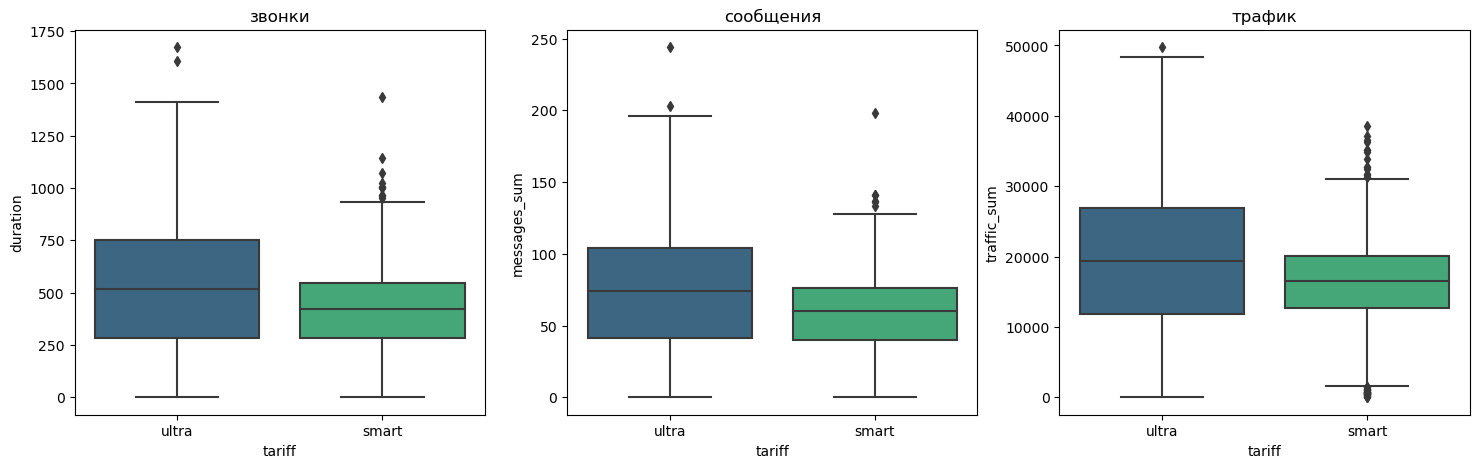

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(ax=axes[0], data=monthly_users, x='tariff', y='duration', palette='viridis')
axes[0].set_title('звонки')
sns.boxplot(ax=axes[1], data=monthly_users, x='tariff', y='messages_sum', palette='viridis')
axes[1].set_title('сообщения')
sns.boxplot(ax=axes[2], data=monthly_users, x='tariff', y='traffic_sum', palette='viridis')
axes[2].set_title('трафик')
plt.show()

In [28]:
smart = monthly_users.query('tariff == "smart"')
ultra = monthly_users.query('tariff == "ultra"')

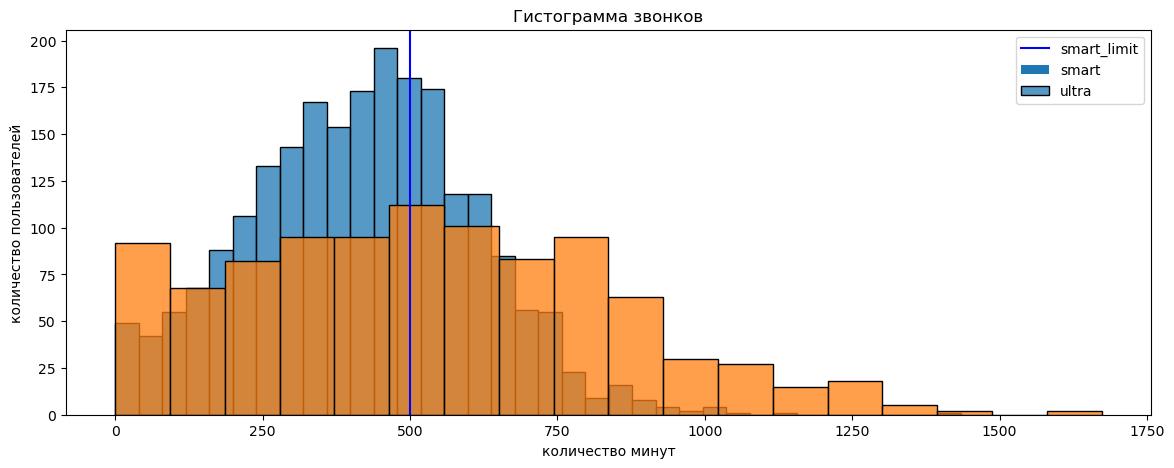

ultra_limit = 3000 минут


In [29]:
smart_limit = tariffs.query('tariff_name == "smart"')['minutes_included'][0]
plt.figure(figsize=(14, 5))
sns.histplot(smart['duration'], kde=False)
sns.histplot(ultra['duration'], kde=False)
plt.axvline(x=smart_limit, c='blue')
plt.legend(['smart_limit', 'smart', 'ultra'])
plt.xlabel('количество минут')
plt.ylabel('количество пользователей')
plt.title('Гистограмма звонков')
plt.show()
print('ultra_limit = 3000 минут')

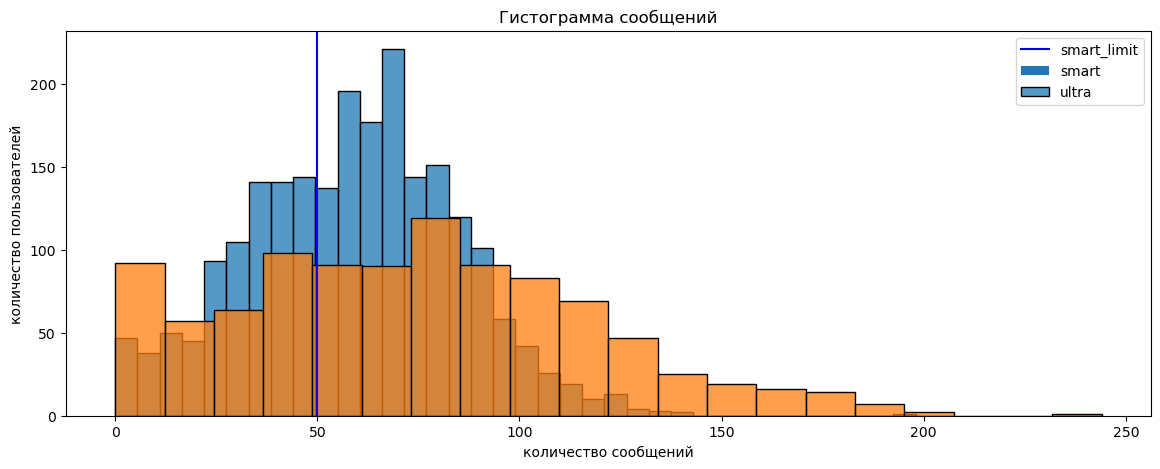

ultra_limit = 1000 сообщений


In [30]:
smart_limit = tariffs.query('tariff_name == "smart"')['messages_included'][0]
plt.figure(figsize=(14, 5))
sns.histplot(smart['messages_sum'], kde=False)
sns.histplot(ultra['messages_sum'], kde=False)
plt.axvline(x=smart_limit, c='blue')
plt.legend(['smart_limit', 'smart', 'ultra'])
plt.xlabel('количество сообщений')
plt.ylabel('количество пользователей')
plt.title('Гистограмма сообщений')
plt.show()
print('ultra_limit = 1000 сообщений')

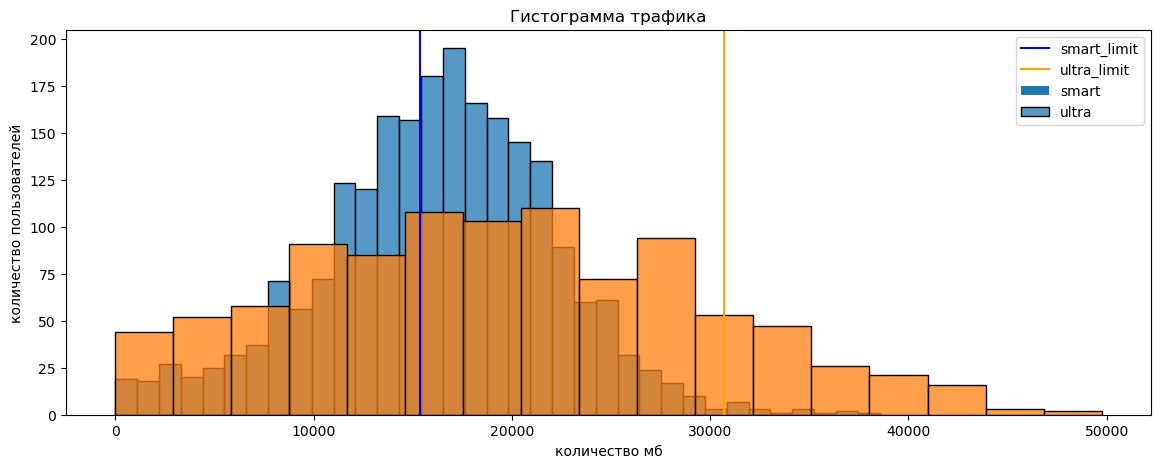

In [31]:
smart_limit = tariffs.query('tariff_name == "smart"')['mb_per_month_included'][0]
ultra_limit = tariffs.query('tariff_name == "ultra"')['mb_per_month_included'][1]
plt.figure(figsize=(14, 5))
sns.histplot(smart['traffic_sum'], kde=False)
sns.histplot(ultra['traffic_sum'], kde=False)
plt.axvline(x=smart_limit, c='blue')
plt.axvline(x=ultra_limit, c='orange')
plt.legend(['smart_limit', 'ultra_limit', 'smart', 'ultra'])
plt.xlabel('количество мб')
plt.ylabel('количество пользователей')
plt.title('Гистограмма трафика')
plt.show()

***
### Вывод

Из графиков видно:
* Количество клиентов, у которых потребление услуг выше медианного значения, больше у клиентов тарифа «Ультра».
* Потребление услуг клиентами тарифа «Ультра» более распределено по сравнению с клиентами «Смарт».
* Потребление услуг клиентов тарифа «Смарт» сконцентрировано вокруг ограничения пакета.  
   При этом б́ольшая часть клиентов превышает лимит.<br><br>
***

## Проверка гипотез

### Гипотеза №1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

H0: Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны.  
H1: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.  
Критический уровень статистической значимости принимаю равным 5%.  
Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей,  
применю метод `scipy.stats.ttest_ind()`  

In [32]:
alpha = .05
results = st.ttest_ind(smart['income'], ultra['income'], equal_var=False)
print('p-значение: {:%}'.format(results.pvalue))
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу.")
    print("Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")
    print("Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны.")

p-значение: 0.000000%
Отвергаем нулевую гипотезу.
Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.


### Гипотеза №2. Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

H0: Cредняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.  
H1: Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.  
Критический уровень статистической значимости принимаю равным 5%.  
Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей,  
применю метод `scipy.stats.ttest_ind()`  

In [33]:
alpha = .05
moscow = monthly_users.merge(users[['user_id', 'city',]], on='user_id', how='left').query('city == "Москва"')['income']
not_moscow = monthly_users.merge(users[['user_id', 'city',]], on='user_id', how='left').query('city != "Москва"')['income']
results = st.ttest_ind(moscow, not_moscow, equal_var=False)
print('p-значение: {:.2%}'.format(results.pvalue))
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу.")
    print("Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")
    print("Cредняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.")

p-значение: 53.05%
Не получилось отвергнуть нулевую гипотезу.
Cредняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.


## Общий вывод

* Медианная выручка тарифа «Ультра» больше, чем выручка тарифа «Смарт» (2061 руб. > 1337 руб.)
* Клиенты тарифа «Ультра» не «выбирают» полностью пакеты услуг по звонкам и по сообщениям,  
   и основная масса не перерасходует лимит по трафику.
* Большинство клиентов тарифа «Смарт» превышают лимиты пакетов услуг.
* Клиентов тарифа «Смарт» практически в два раза больше клиентов «Ультра».
* Cредняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.
* Тариф «Ультра» более выгоден, исходя из того, что клиенты «Ультра» не перерасходуют лимиты по пакетам услуг и при этом выручка больше, чем по тарифу «Смарт».
* Возраст, дата подключения тарифа и дата отключения таблицы `users` не понадобились для анализа.